In [2]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

ERROR:root:Line magic function `%install_ext` not found.


In [3]:
%pylab inline
from snakebite.client import Client
import pyaml as yaml
import sys
import pythonrun
reload(pythonrun)
import os
import seaborn as sns
from sklearn import metrics
import scala_python_endive_wrapper
reload(scala_python_endive_wrapper)
from scala_python_endive_wrapper import *
import pandas as pd

Populating the interactive namespace from numpy and matplotlib
time: 717 ms


In [4]:
hdfsclient = Client("amp-spark-master.amp", 8020, use_trash=False)
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')
logpath = "/tmp/log"

time: 3.76 ms


In [5]:

executor_mem = "100g"
cores_per_executor = 32
num_executors = 14

time: 2.32 ms


In [7]:
# CHANGE ME
dataset_creation_config = \
{
    "labels": "/user/vaishaal/endive-data/ChIPseq/labels/EGR1.train.labels.tsv", \
    "reference": "/home/eecs/akmorrow/ADAM/endive/workfiles/hg19.2bit", \
    "dnase": "/user/vaishaal/endive-data/DNASE/peaks/relaxed/", \
    "aggregatedSequenceOutput": "/user/vaishaal/endive-data/aggregated/EGR1/"
}

EGR1_PATH = "/user/vaishaal/endive-data/aggregated/EGR1/EGR1"
ATF2_PATH = "/user/vaishaal/endive-data/aggregated/ATF2/ATF2"


time: 4.85 ms


In [21]:
# Run scala job send output to terminal to create windows
sys.stdout = terminal_stdout
sys.stderr = terminal_stderr
pythonrun.run(dataset_creation_config, 
              logpath,
              dataset_creation_pipeline_class, 
              pipeline_jar, 
              executor_mem,
              cores_per_executor, 
              num_executors,
              use_yarn=True)

In [6]:
sys.stdout = notebook_stdout
sys.stderr = notebook_stderr
os.system("mkdir -p {0}".format(kernel_pipeline_config["predictionsOutput"]))

NameError: name 'kernel_pipeline_config' is not defined

time: 172 ms


In [ ]:
# this is where the magic happens
results = [] 
gammas = []
kmer_size = []
for ks in [4,8,16,32]:
     res = run_kernel_pipeline(EGR1_PATH,
                           "/tmp/filters.csv", 
                           logpath, 
                           seed=0,
                           gamma=1.0,
                           kmer_size=ks,
                           filter_gen_gen=make_gaussian_filter_gen)
     kmer_size.append(ks)
     results.append(res)

(256, 16)


In [10]:
print results

[((array([ 1.,  1.,  1., ...,  0.,  0.,  0.]), array([ 0.27413205, -1.00555857,  1.63984252, ..., -0.78495969,
       -0.76365317,  0.04481421])), (array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([-0.88500111, -1.16497844, -0.8237223 , ..., -0.6231709 ,
       -0.67461351, -1.11767469]))), ((array([ 1.,  1.,  1., ...,  0.,  0.,  0.]), array([-0.17594227,  1.4507175 ,  0.34594481, ..., -0.9908137 ,
       -0.76665399, -0.77775572])), (array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([-0.80892192, -1.0545436 , -0.74383333, ..., -1.01291721,
       -0.42208821, -0.46117627]))), ((array([ 1.,  1.,  1., ...,  0.,  0.,  0.]), array([-0.37614959, -0.19702391,  0.48065335, ..., -1.1740738 ,
       -0.56749549, -0.62663599])), (array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([-0.61470378, -0.47555886, -0.84674222, ..., -0.22803557,
       -1.21915973, -0.81287803]))), ((array([ 1.,  1.,  1., ...,  0.,  0.,  0.]), array([-0.62864853, -0.67643909, -0.69716   , ..., -0.70886978,
       -0.694

#### ROC Metrics

In [12]:
df_base = []
for i,res in enumerate(results):
    ((y_train, y_train_pred), (y_test, y_test_pred)) = res
    result = {}
    sys.stdout = notebook_stdout
    sys.stderr = notebook_stderr
    train_roc_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_roc_auc = metrics.roc_auc_score(y_test, y_test_pred)
    train_pr_auc = metrics.average_precision_score(y_train, y_train_pred)
    test_pr_auc = metrics.average_precision_score(y_test, y_test_pred)
    result['gamma'] = 1.0
    result['train_roc'] = train_roc_auc
    result['test_roc'] = test_roc_auc
    result['train_pr'] = train_pr_auc
    result['test_pr'] = test_pr_auc
    result['kmer_size'] = kmer_size[i]
    result['seed'] = 0
    df_base.append(result)

time: 9.53 s


In [13]:
df = pd.DataFrame(df_base)

time: 3.58 ms


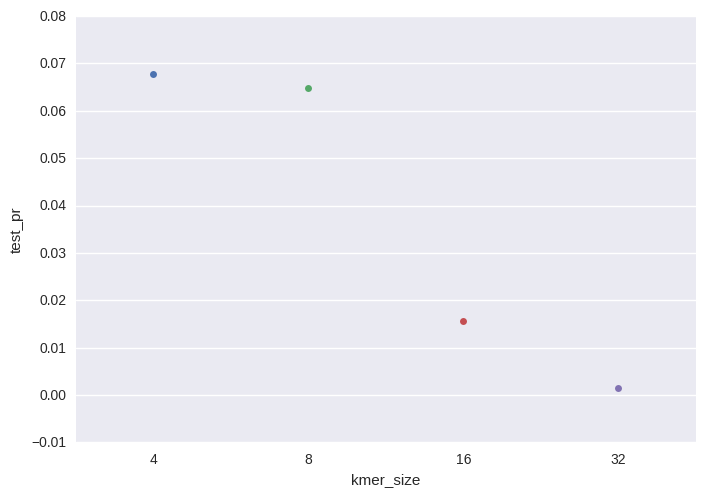

time: 359 ms


In [14]:
sns.stripplot(x='kmer_size', y='test_pr', data=df)

#### PR Metrics

Train PR AUC 0.757754546452
Test PR AUC 0.121105773929


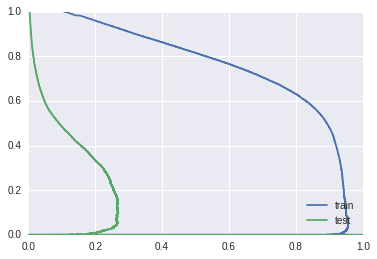

time: 2.96 s


In [68]:
sys.stdout = notebook_stdout
sys.stderr = notebook_stderr
fpr, tpr, thresh = metrics.precision_recall_curve(y_train, y_train_pred)
train_auc = metrics.average_precision_score(y_train, y_train_pred)
plot(fpr, tpr, label="train")

fpr, tpr, thresh = metrics.precision_recall_curve(y_test, y_test_pred)
test_auc = metrics.average_precision_score(y_test, y_test_pred)

plot(fpr, tpr, label="test")

plt.legend(loc=4)
plt.figure()
print("Train PR AUC {0}".format(train_auc))
print("Test PR AUC {0}".format(test_auc))